In [ ]:
! pip install --upgrade verde ensaio boule git+https://github.com/fatiando/harmonica cffi==1.16.0 numba

  Cloning https://github.com/fatiando/harmonica to /tmp/pip-req-build-o4cowqyr
  Running command git clone --filter=blob:none --quiet https://github.com/fatiando/harmonica /tmp/pip-req-build-o4cowqyr
  Resolved https://github.com/fatiando/harmonica to commit bbaf5a191c7a3ccf9835a2d3b565be26a3500d26
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import ensaio

In [ ]:
def euler_deconv(grid, structural_index, window_size=None, window_spacing=None, keep=100):
    data = vd.grid_to_table(grid)
    data["upward"] = grid.upward.values.ravel()

    if window_size is None:
        windows = np.array([[[np.arange(data.shape[0])]]])
    else:
        if window_spacing is None:
            window_spacing = 0.2 * window_size
        _, windows = vd.rolling_window((data.easting, data.northing), size=window_size, spacing=window_spacing)

    coordinates = []
    quality = []
    base_levels = []
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            data_window = data.iloc[windows[i, j][0]]
            A = np.empty((data_window.shape[0], 4))
            A[:, 0] = data_window.d_east
            A[:, 1] = data_window.d_north
            A[:, 2] = data_window.d_up
            A[:, 3] = structural_index
            data_vector = (
                data_window.d_east * data_window.easting
                + data_window.d_north * data_window.northing
                + data_window.d_up * data_window.upward
                + structural_index * data_window.tfa
            )
            estimate = scipy.linalg.solve(A.T @ A, A.T @ data_vector)
            if estimate[2] > data_window.upward.min():
                continue
            if estimate[0] > data_window.easting.max() or estimate[0] < data_window.easting.min():
                continue
            if estimate[1] > data_window.northing.max() or estimate[1] < data_window.northing.min():
                continue
            covariance = scipy.linalg.inv(A.T @ A) * np.sum((data_vector - A @ estimate)**2) / (A.shape[0] - A.shape[1])
            quality.append(np.sum(np.sqrt(np.diagonal(covariance)[:3])))
            coordinates.append(estimate[:3])
            base_levels.append(estimate[3])
    best = np.argsort(quality)[:int(keep / 100 * len(coordinates))]
    return np.array(coordinates)[best], np.array(base_levels)[best]

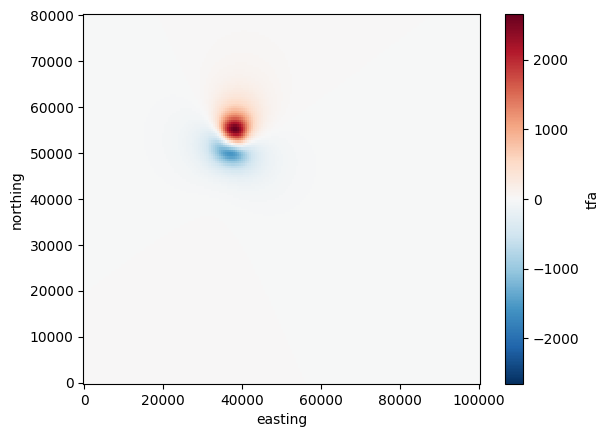

In [ ]:
model = [
    [35e3, 40e3, 50e3, 55e3, -6e3, -1e3],
]
magnetization = [
    hm.magnetic_angles_to_vec(20, -40, 15),
]

inc, dec = -40, 15
fe, fn, fu = hm.magnetic_angles_to_vec(1, inc, dec)
region = [0, 100e3, 0, 80e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=1000)

be, bn, bu = hm.prism_magnetic(coordinates, model, np.transpose(magnetization), field="b")
anomalia = fe * be + fn * bn + fu * bu

grid = vd.make_xarray_grid(coordinates, anomalia, data_names="tfa", extra_coords_names="upward")

grid.tfa.plot()

/usr/local/lib/python3.10/dist-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


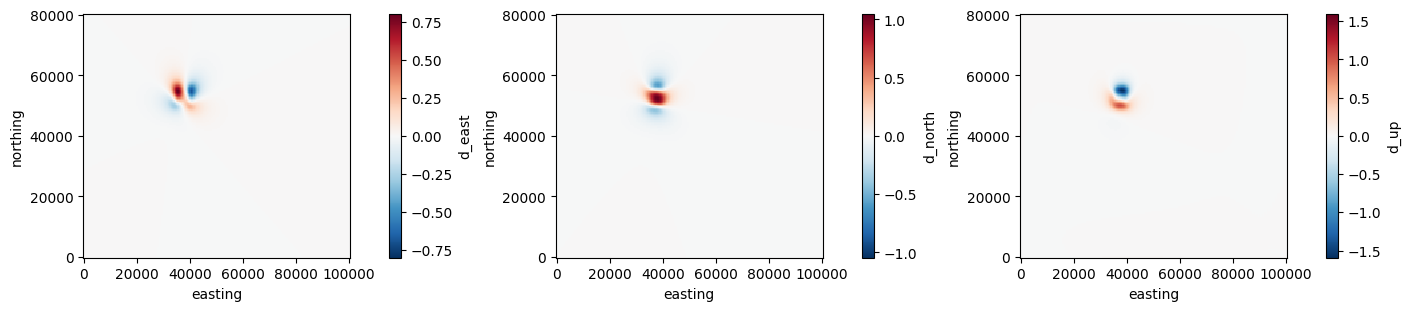

In [ ]:
grid["d_east"] = hm.derivative_easting(grid.tfa)
grid["d_north"] = hm.derivative_northing(grid.tfa)
grid["d_up"] = -hm.derivative_upward(grid.tfa)

fig, axes = plt.subplots(1, 3, layout="constrained", figsize=(14, 3))
grid.d_east.plot(ax=axes[0])
grid.d_north.plot(ax=axes[1])
grid.d_up.plot(ax=axes[2])

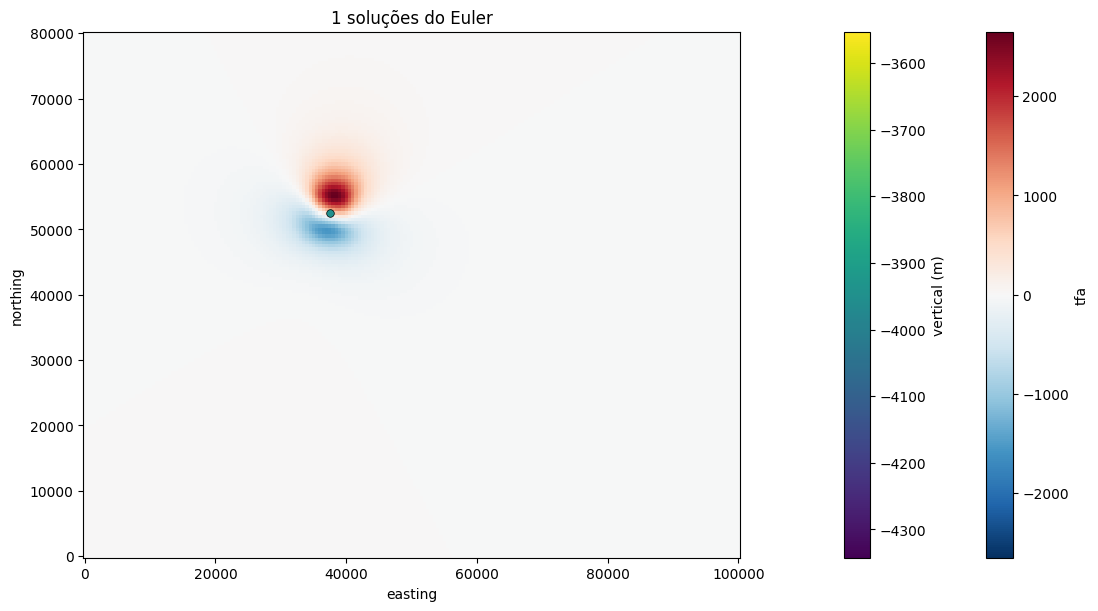

In [ ]:
estimativas, base_levels = euler_deconv(grid, structural_index=3)

plt.figure(figsize=(11, 6), layout="constrained")
grid.tfa.plot()
plt.title(f"{len(estimativas)} soluções do Euler")
plt.scatter(*np.transpose(estimativas)[:2], c=np.transpose(estimativas)[2], s=30, linewidths=0.5, edgecolors="k")
plt.colorbar(label="vertical (m)")
plt.axis("scaled")
plt.show()